In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os
from pathlib import Path

from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve, cross_val_score
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, SGDRegressor, Ridge, Lasso, LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, classification_report, accuracy_score
from sklearn.pipeline import Pipeline

In [2]:
def load_wine_data():
    url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv"
    return pd.read_csv(url, sep=';')

In [3]:
wine_df = load_wine_data()

In [4]:
print(wine_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB
None


In [5]:
print(wine_df.describe())

       fixed acidity  volatile acidity  citric acid  residual sugar  \
count    1599.000000       1599.000000  1599.000000     1599.000000   
mean        8.319637          0.527821     0.270976        2.538806   
std         1.741096          0.179060     0.194801        1.409928   
min         4.600000          0.120000     0.000000        0.900000   
25%         7.100000          0.390000     0.090000        1.900000   
50%         7.900000          0.520000     0.260000        2.200000   
75%         9.200000          0.640000     0.420000        2.600000   
max        15.900000          1.580000     1.000000       15.500000   

         chlorides  free sulfur dioxide  total sulfur dioxide      density  \
count  1599.000000          1599.000000           1599.000000  1599.000000   
mean      0.087467            15.874922             46.467792     0.996747   
std       0.047065            10.460157             32.895324     0.001887   
min       0.012000             1.000000         

In [6]:
print(wine_df["quality"].value_counts())

quality
5    681
6    638
7    199
4     53
8     18
3     10
Name: count, dtype: int64


In [7]:
# Data preprocessing
# Handle missing values with SimpleImputer
imputer = SimpleImputer(strategy="median")
wine_df[wine_df.columns] = imputer.fit_transform(wine_df)

In [8]:
# Feature and target split
X = wine_df.drop("quality", axis=1)
y = wine_df["quality"]

In [9]:
# Binary classification for logistic regression (quality >= 6 -> good)
y_class = (y >= 6).astype(int)

In [10]:
# Split for regression and classification
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
Xc_train, Xc_test, yc_train, yc_test = train_test_split(X, y_class, test_size=0.2, random_state=42)

In [11]:
# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
Xc_train_scaled = scaler.fit_transform(Xc_train)
Xc_test_scaled = scaler.transform(Xc_test)

In [12]:
# Polynomial feature expansion
poly = PolynomialFeatures(degree=2, include_bias=False)
X_train_poly = poly.fit_transform(X_train_scaled)
X_test_poly = poly.transform(X_test_scaled)

In [13]:
# Linear Regression (Normal Equation)
lin_reg = LinearRegression()
lin_reg.fit(X_train_poly, y_train)
y_pred_lr = lin_reg.predict(X_test_poly)
print("Linear Regression R2:", r2_score(y_test, y_pred_lr))
lin_scores = cross_val_score(lin_reg, X_train_poly, y_train, scoring="r2", cv=5)
print("Linear Regression Cross-Val R2 Scores:", lin_scores)
print("Linear Regression R2 Mean:", lin_scores.mean())

Linear Regression R2: 0.4156800644102854
Linear Regression Cross-Val R2 Scores: [0.16765562 0.31825126 0.1242174  0.22318809 0.34835004]
Linear Regression R2 Mean: 0.23633248210502683


In [14]:
# SGD Regressor
sgd_reg = SGDRegressor(max_iter=1000, tol=1e-3, random_state=42)
sgd_reg.fit(X_train_scaled, y_train)
y_pred_sgd = sgd_reg.predict(X_test_scaled)
print("SGD Regressor R2:", r2_score(y_test, y_pred_sgd))
sgd_scores = cross_val_score(sgd_reg, X_train_scaled, y_train, scoring="r2", cv=5)
print("SGD Regressor Cross-Val R2 Scores:", sgd_scores)
print("SGD Regressor R2 Mean:", sgd_scores.mean())

SGD Regressor R2: 0.4007375123450756
SGD Regressor Cross-Val R2 Scores: [0.27073087 0.30411606 0.29252293 0.31517908 0.4339777 ]
SGD Regressor R2 Mean: 0.32330532941862333


In [15]:
# Ridge and Lasso Regression
ridge = Ridge()
lasso = Lasso()

param_grid = {'alpha': [0.01, 0.1, 1, 10]}
grid_ridge = GridSearchCV(ridge, param_grid, cv=5, scoring='r2')
grid_lasso = GridSearchCV(lasso, param_grid, cv=5, scoring='r2')

grid_ridge.fit(X_train_scaled, y_train)
grid_lasso.fit(X_train_scaled, y_train)

print("Best Ridge R2:", grid_ridge.best_score_)
print("Best Lasso R2:", grid_lasso.best_score_)

Best Ridge R2: 0.32236547301415064
Best Lasso R2: 0.3233557394698264


In [16]:
# Random Forest Regressor
forest_reg = RandomForestRegressor(random_state=42)
forest_reg.fit(X_train_scaled, y_train)
y_pred_rf = forest_reg.predict(X_test_scaled)
print("Random Forest Regressor R2:", r2_score(y_test, y_pred_rf))
rf_scores = cross_val_score(forest_reg, X_train_scaled, y_train, scoring="r2", cv=5)
print("Random Forest Cross-Val R2 Scores:", rf_scores)
print("Random Forest R2 Mean:", rf_scores.mean())

Random Forest Regressor R2: 0.5399271357910311
Random Forest Cross-Val R2 Scores: [0.33864761 0.45400152 0.37672825 0.42444993 0.53410265]
Random Forest R2 Mean: 0.4255859917888964


In [17]:
# Logistic Regression
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(Xc_train_scaled, yc_train)
yc_pred = log_reg.predict(Xc_test_scaled)
print(classification_report(yc_test, yc_pred))
print("Accuracy Score:", accuracy_score(yc_test, yc_pred))

              precision    recall  f1-score   support

           0       0.69      0.74      0.72       141
           1       0.79      0.74      0.76       179

    accuracy                           0.74       320
   macro avg       0.74      0.74      0.74       320
weighted avg       0.74      0.74      0.74       320

Accuracy Score: 0.740625


In [18]:
def plot_learning_curve(estimator, X, y, title):
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=5,
                                                            scoring='r2',
                                                            train_sizes=np.linspace(0.1, 1.0, 5))
    train_scores_mean = np.mean(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)

    plt.plot(train_sizes, train_scores_mean, label="Training score")
    plt.plot(train_sizes, test_scores_mean, label="Cross-validation score")
    plt.title(title)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    plt.legend(loc="best")
    plt.grid()
    plt.show()

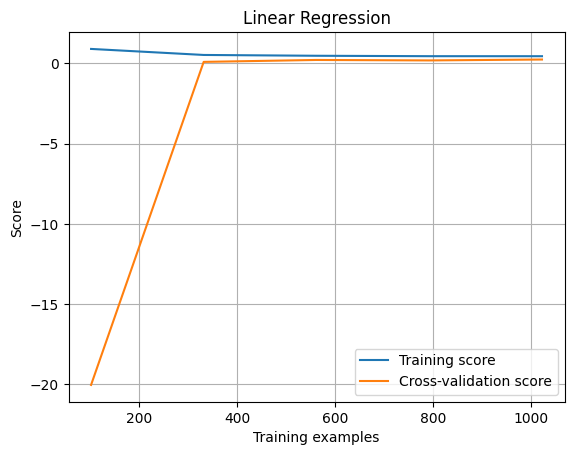

In [19]:
# Linear Regression
plot_learning_curve(lin_reg, X_train_poly, y_train, "Linear Regression")

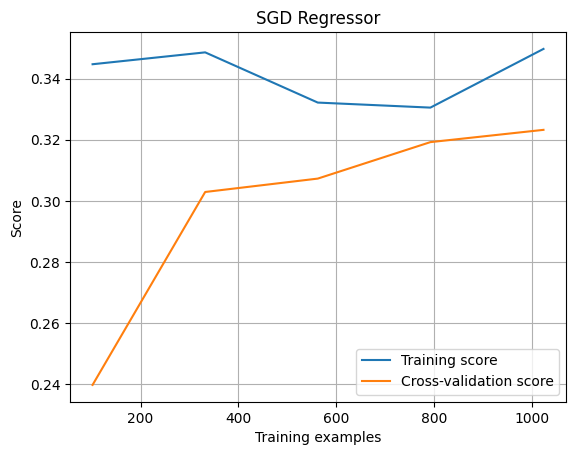

In [20]:
# SGD
plot_learning_curve(sgd_reg, X_train_scaled, y_train, "SGD Regressor")

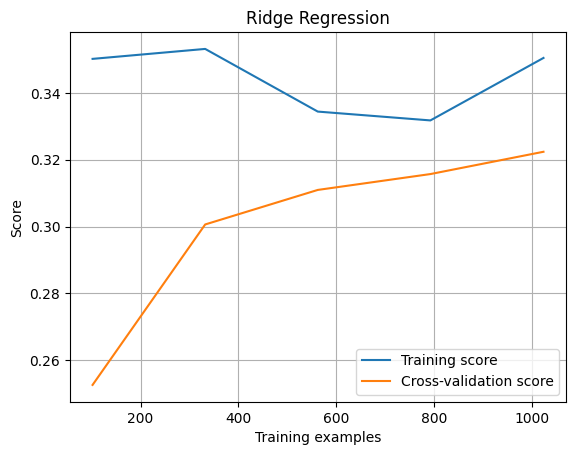

In [21]:
# Ridge
plot_learning_curve(grid_ridge.best_estimator_, X_train_scaled, y_train, "Ridge Regression")

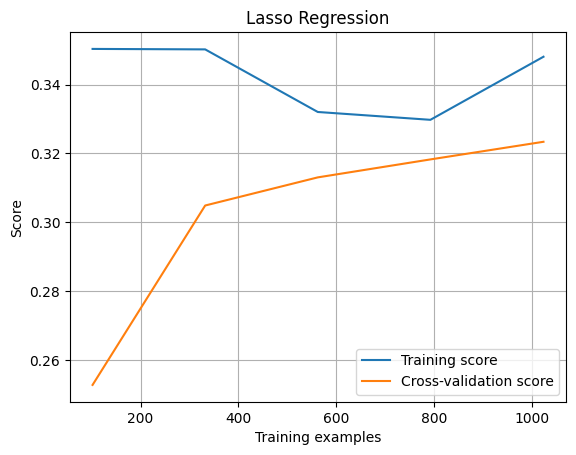

In [22]:
# Lasso
plot_learning_curve(grid_lasso.best_estimator_, X_train_scaled, y_train, "Lasso Regression")

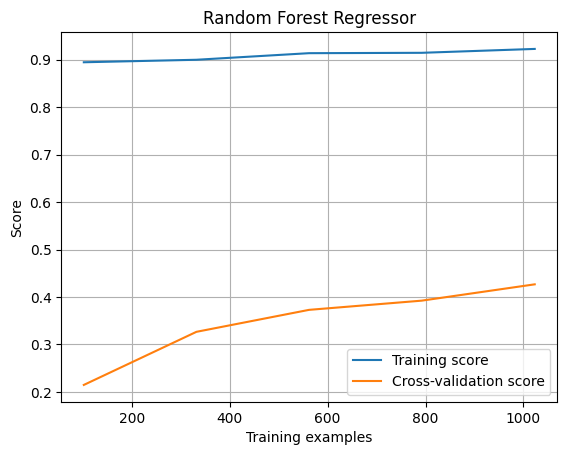

In [23]:
# Random Forest (Simple)
plot_learning_curve(forest_reg, X_train_scaled, y_train, "Random Forest Regressor")

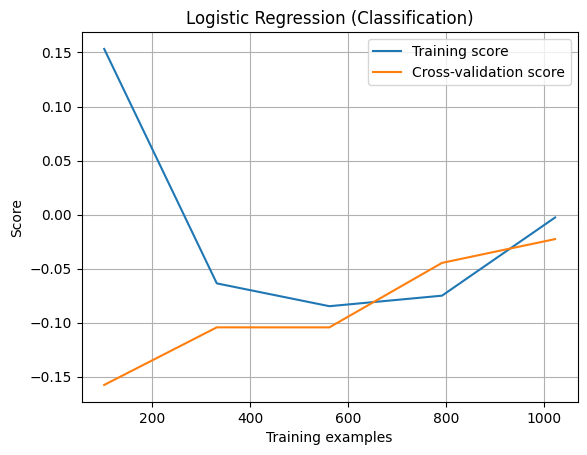

In [24]:
# Logistic Regression
plot_learning_curve(log_reg, Xc_train_scaled, yc_train, "Logistic Regression (Classification)")

In [25]:
from sklearn.metrics import mean_squared_error, r2_score, classification_report
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import time
results = []
def evaluate_model(name, model, X_train, X_test, y_train, y_test, is_classifier=False):
    start = time.time()
    model.fit(X_train, y_train)
    duration = time.time() - start
    y_pred = model.predict(X_test)

    if is_classifier:
        acc = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        results.append([name, None, None, acc, f1, duration])
    else:
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        r2 = r2_score(y_test, y_pred)
        results.append([name, rmse, r2, None, None, duration])

In [26]:
evaluate_model("Linear Regression", LinearRegression(), X_train_poly, X_test_poly, y_train, y_test)
evaluate_model("SGD Regressor", SGDRegressor(max_iter=1000, tol=1e-3, random_state=42), X_train_scaled, X_test_scaled, y_train, y_test)
evaluate_model("Ridge", grid_ridge.best_estimator_, X_train_scaled, X_test_scaled, y_train, y_test)
evaluate_model("Lasso", grid_lasso.best_estimator_, X_train_scaled, X_test_scaled, y_train, y_test)
evaluate_model("Random Forest", forest_reg, X_train_scaled, X_test_scaled, y_train, y_test)

In [27]:
evaluate_model("Logistic Regression", LogisticRegression(max_iter=1000), Xc_train_scaled, Xc_test_scaled, yc_train, yc_test, is_classifier=True)

In [28]:
summary_df = pd.DataFrame(results, columns=["Model", "RMSE", "R2", "Accuracy", "F1 Score", "Train Time (s)"])
print("\nModel Comparison Table:")
print(summary_df)


Model Comparison Table:
                 Model      RMSE        R2  Accuracy  F1 Score  Train Time (s)
0    Linear Regression  0.617945  0.415680       NaN       NaN        0.025292
1        SGD Regressor  0.625797  0.400738       NaN       NaN        0.002001
2                Ridge  0.624641  0.402948       NaN       NaN        0.001000
3                Lasso  0.626909  0.398605       NaN       NaN        0.000000
4        Random Forest  0.548325  0.539927       NaN       NaN        0.803471
5  Logistic Regression       NaN       NaN  0.740625  0.760807        0.014683


In [29]:
feature_names = X.columns
importances = forest_reg.feature_importances_
indices = np.argsort(importances)[::-1]

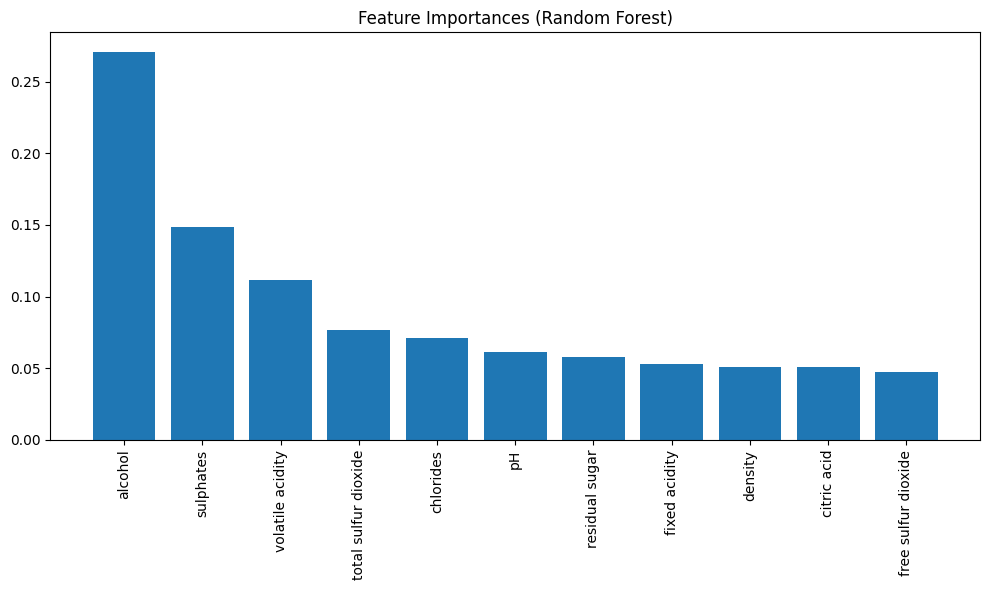

In [30]:
plt.figure(figsize=(10, 6))
plt.title("Feature Importances (Random Forest)")
plt.bar(range(X.shape[1]), importances[indices], align="center")
plt.xticks(range(X.shape[1]), feature_names[indices], rotation=90)
plt.tight_layout()
plt.show()

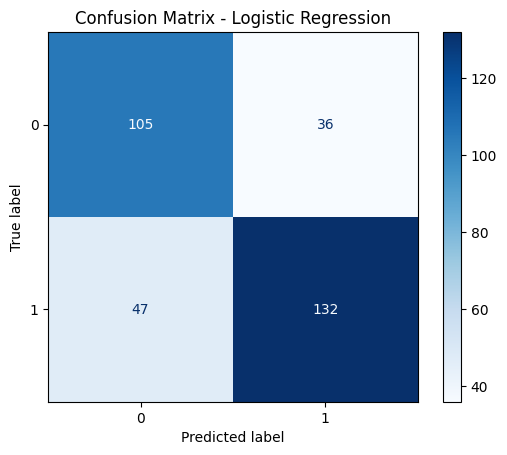

In [31]:
# Confusion Matrix (Logistic Regression)
yc_pred_log = LogisticRegression(max_iter=1000).fit(Xc_train_scaled, yc_train).predict(Xc_test_scaled)
cm = confusion_matrix(yc_test, yc_pred_log)
ConfusionMatrixDisplay(confusion_matrix=cm).plot(cmap="Blues")
plt.title("Confusion Matrix - Logistic Regression")
plt.grid(False)
plt.show()